# 02 – Label Analysis

Analyze label quality and annotator behavior using exported annotations. This notebook relies on `all_annotations.csv`, `majority_labels.csv`, and the `label_summary.json` created during preprocessing.

In [1]:
from pathlib import Path
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

output_root = Path("/app/output")
annotations_path = output_root / "all_annotations.csv"
majority_path = output_root / "majority_labels.csv"
summary_path = output_root / "label_summary.json"

annotations = pd.read_csv(annotations_path) if annotations_path.exists() else pd.DataFrame()
majority = pd.read_csv(majority_path) if majority_path.exists() else pd.DataFrame()
summary = json.loads(summary_path.read_text(encoding="utf-8")) if summary_path.exists() else {}


## Class distribution (majority labels)

In [2]:
if majority.empty:
    print("Majority labels missing; run preprocessing first.")
else:
    counts = majority["majority_label"].value_counts().sort_index()
    display(counts)

    plt.figure(figsize=(6, 4))
    sns.barplot(x=counts.index, y=counts.values, color="steelblue")
    plt.title("Class distribution (majority labels)")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=30)
    (output_root / "figures").mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(output_root / "figures" / "class_distribution.png", dpi=150)
    plt.show()


Majority labels missing; run preprocessing first.


## Annotator activity

Annotations per annotator:


annotator
C6037J                                    91
DN04PZ                                    79
D6AE9F                                    78
FGWUFP                                    77
b8v41y                                    77
YY0APN                                    77
OJHGS8                                    77
D0V869                                    65
NX9GA4                                    57
GK1XQ4                                    57
XV0M8Z                                    57
NC1O2T                                    57
YLEX88                                    57
FO6K58                                    56
h51b9j                                    56
project-1-at-2025-10-15-23-46-9d203653    52
ODZF0M                                    48
FO6K58_labels                             32
ECSGGY                                    30
H51B9J                                    23
ITWQ3V                                    22
project-2-at-2025-10-16-02-08-8ee4fdfa    20


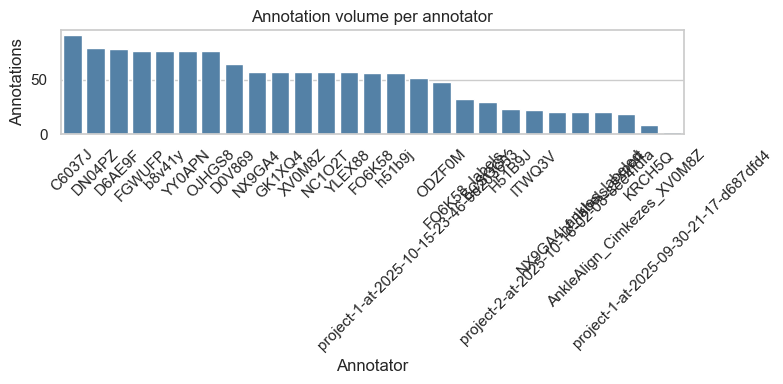

In [8]:
if annotations.empty:
    print("Annotation file missing; run preprocessing first.")
else:
    per_annotator = annotations.groupby("annotator").size().sort_values(ascending=False)
    print("Annotations per annotator:")
    display(per_annotator)

    plt.figure(figsize=(8, 4))
    sns.barplot(x=per_annotator.index, y=per_annotator.values, color="steelblue")
    plt.title("Annotation volume per annotator")
    plt.xlabel("Annotator")
    plt.ylabel("Annotations")
    plt.xticks(rotation=45)
    (output_root / "figures").mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(output_root / "figures" / "annotator_volume.png", dpi=150)
    plt.show()


## Agreement with majority label

Annotator agreement with majority:


annotator
D0V869                                    1.000000
H51B9J                                    1.000000
hf_labels_export                          1.000000
project-2-at-2025-10-16-02-08-8ee4fdfa    1.000000
project-1-at-2025-10-15-23-46-9d203653    1.000000
project-1-at-2025-09-30-21-17-d687dfd4    1.000000
NX9GA4_ankles_labeled                     0.950000
DN04PZ                                    0.936709
ODZF0M                                    0.916667
C6037J                                    0.912088
h51b9j                                    0.857143
b8v41y                                    0.857143
YY0APN                                    0.831169
NX9GA4                                    0.824561
NC1O2T                                    0.807018
FO6K58                                    0.750000
AnkleAlign_Cimkezes_XV0M8Z                0.736842
OJHGS8                                    0.727273
XV0M8Z                                    0.684211
ITWQ3V               

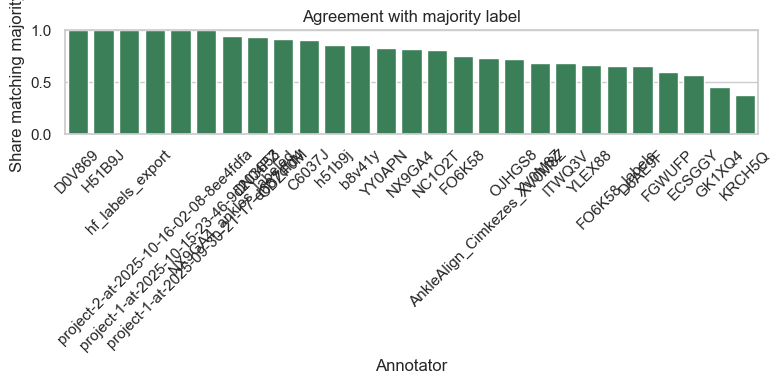

In [9]:
if annotations.empty or majority.empty:
    print("Annotations or majority labels missing; run preprocessing first.")
else:
    merged = annotations.merge(majority, on="file_upload", how="left", suffixes=("_annot", "_majority"))
    merged = merged.dropna(subset=["majority_label"])  # keep images with consensus

    merged["matches_majority"] = merged["label"] == merged["majority_label"]
    agreement = merged.groupby("annotator")["matches_majority"].mean().sort_values(ascending=False)
    print("Annotator agreement with majority:")
    display(agreement)

    plt.figure(figsize=(8, 4))
    sns.barplot(x=agreement.index, y=agreement.values, color="seagreen")
    plt.title("Agreement with majority label")
    plt.xlabel("Annotator")
    plt.ylabel("Share matching majority")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(output_root / "figures" / "annotator_agreement.png", dpi=150)
    plt.show()


## Confusion between annotators (pairwise)

In [10]:
if annotations.empty:
    print("Annotations missing; run preprocessing first.")
else:
    # Pivot to image x annotator table
    pivot = annotations.pivot_table(index="file_upload", columns="annotator", values="label", aggfunc=lambda x: x.iloc[0])
    pivot = pivot.dropna(how="all")
    print(f"Pivot shape: {pivot.shape}")

    # Compute pairwise agreement rates
    agreement_rows = []
    annotators = pivot.columns.tolist()
    for i, a1 in enumerate(annotators):
        for a2 in annotators[i + 1:]:
            df_pair = pivot[[a1, a2]].dropna()
            if df_pair.empty:
                continue
            agreement_rate = (df_pair[a1] == df_pair[a2]).mean()
            agreement_rows.append({"annotator_a": a1, "annotator_b": a2, "agreement": agreement_rate})

    agreement_df = pd.DataFrame(agreement_rows)
    display(agreement_df.sort_values(by="agreement", ascending=False).head(10))


Pivot shape: (423, 27)


,annotator_a,annotator_b,agreement
65,DN04PZ,OJHGS8,1.0
28,C6037J,OJHGS8,1.0
34,D0V869,FGWUFP,1.0
8,AnkleAlign_Cimkezes_XV0M8Z,NX9GA4_ankles_labeled,1.0
156,NC1O2T,OJHGS8,1.0
173,NX9GA4_ankles_labeled,b8v41y,1.0
183,OJHGS8,YY0APN,1.0
185,OJHGS8,h51b9j,1.0
172,NX9GA4_ankles_labeled,YY0APN,1.0
170,NX9GA4_ankles_labeled,XV0M8Z,1.0
